# 🧠 Part 1: Building Optimized CNN from Scratch
## גרסה מיוטבת - מהירה + פחות overfitting!

---

### ✨ שיפורים בגרסה הזו:
1. **מודל קל יותר** - 3 conv layers אבל פחות channels (16→32→64)
2. **dropout חזק יותר** - 0.6 במקום 0.5 למניעת overfitting
3. **פחות epochs** - 25 במקום 50 (חיסכון זמן!)
4. **Early Stopping** - עצירה אוטומטית אחרי 5 epochs ללא שיפור
5. **3 FC layers** - מעבר הדרגתי יותר (256→128→4)

### 📊 תוצאות צפויות:
- ⏱️ זמן אימון: ~20-30 דקות (במקום 2+ שעות!)
- 📉 פחות overfitting
- 🎯 accuracy דומה או טוב יותר

## 1️⃣ ייבוא ספריות

In [1]:
import os
import sys
from pathlib import Path
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append(str(Path.cwd().parent / 'src'))
import config

print("✅ All libraries imported!")
print(f"🖥️  Device: {config.DEVICE}")
print(f"📦 Batch size: {config.BATCH_SIZE}")
print(f"📈 Learning rate: {config.LEARNING_RATE}")
print(f"🔢 Max Epochs: {config.NUM_EPOCHS}")
print(f"⏸️  Early Stopping Patience: {config.PATIENCE}")

✅ All libraries imported!
🖥️  Device: cpu
📦 Batch size: 32
📈 Learning rate: 0.001
🔢 Max Epochs: 25
⏸️  Early Stopping Patience: 5


## 2️⃣ טעינת Dataset Splits

In [2]:
splits_path = config.RESULTS_DIR / 'dataset_splits.json'

with open(splits_path, 'r') as f:
    splits_data = json.load(f)

train_indices = splits_data['train_indices']
val_indices = splits_data['val_indices']
test_indices = splits_data['test_indices']
class_names = splits_data['class_names']
num_classes = splits_data['num_classes']

print("✅ Splits loaded!")
print(f"📊 Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

✅ Splits loaded!
📊 Train: 1466, Val: 314, Test: 315


## 3️⃣ יצירת DataLoaders

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE + 32, config.IMAGE_SIZE + 32)),
    transforms.RandomCrop((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

data_path = config.DATA_PATH

train_dataset_full = ImageFolder(root=str(data_path), transform=train_transforms)
train_dataset = Subset(train_dataset_full, train_indices)

val_dataset_full = ImageFolder(root=str(data_path), transform=val_test_transforms)
val_dataset = Subset(val_dataset_full, val_indices)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ DataLoaders ready! Train: {len(train_loader)} batches, Val: {len(val_loader)} batches")

✅ DataLoaders ready! Train: 46 batches, Val: 10 batches


## 4️⃣ SimpleCNN - גרסה מיוטבת! 🏗️

### 🔥 השינויים:
- **Channels:** 16→32→64 (במקום 32→64)
- **Conv layers:** 3 במקום 2 (יותר עומק, פחות רוחב)
- **FC layers:** 256→128→4 (במקום 512→4)
- **Dropout:** 0.6 ו-0.5 (במקום 0.5 בלבד)

**תוצאה:** ~12M parameters במקום 102M! ⚡

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        # Block 1: 3→16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 224→112
        
        # Block 2: 16→32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 112→56
        
        # Block 3: 32→64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 56→28
        
        # Flatten: 64×28×28 = 50,176
        self.flatten = nn.Flatten()
        
        # FC1: 50176→256
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.6)  # Dropout חזק
        
        # FC2: 256→128
        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        
        # FC3: 128→4
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Conv blocks
        x = self.pool1(self.relu1(self.conv1(x)))  # [B,3,224,224]→[B,16,112,112]
        x = self.pool2(self.relu2(self.conv2(x)))  # [B,16,112,112]→[B,32,56,56]
        x = self.pool3(self.relu3(self.conv3(x)))  # [B,32,56,56]→[B,64,28,28]
        
        # FC layers
        x = self.flatten(x)                        # [B,64,28,28]→[B,50176]
        x = self.dropout1(self.relu4(self.fc1(x)))  # [B,50176]→[B,256]
        x = self.dropout2(self.relu5(self.fc2(x)))  # [B,256]→[B,128]
        x = self.fc3(x)                            # [B,128]→[B,4]
        
        return x

model = SimpleCNN(num_classes=num_classes).to(config.DEVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("✅ SimpleCNN created!")
print(f"🔢 Total parameters: {total_params:,}")
print(f"💾 Model size: ~{total_params * 4 / (1024**2):.1f} MB")
print(f"\n{model}")

✅ SimpleCNN created!
🔢 Total parameters: 12,902,308
💾 Model size: ~49.2 MB

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (relu4): ReLU()
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu5): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


## 5️⃣ Loss & Optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print("✅ Optimizer ready!")

✅ Optimizer ready!


## 6️⃣ פונקציות Train & Validate

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / len(dataloader), 100 * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return running_loss / len(dataloader), 100 * correct / total

print("✅ Training functions ready!")

✅ Training functions ready!


## 7️⃣ לולאת האימון + Early Stopping 🚀

In [7]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0
best_model_path = config.MODELS_DIR / 'simple_cnn_optimized_best.pth'

# Early Stopping
patience = config.PATIENCE
patience_counter = 0

print("🚀 Starting training...")
print(f"   Max Epochs: {config.NUM_EPOCHS}")
print(f"   Early Stopping: {patience} epochs patience")
print(f"   Device: {config.DEVICE}")
print("\n" + "="*80)

start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    # Print
    print(f"Epoch [{epoch+1:2d}/{config.NUM_EPOCHS}] | "
          f"Train: {train_loss:.4f} / {train_acc:5.2f}% | "
          f"Val: {val_loss:.4f} / {val_acc:5.2f}% | "
          f"{epoch_time:.1f}s", end='')
    
    # Save best model & Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, best_model_path)
        print(f" 💾 BEST!")
    else:
        patience_counter += 1
        print(f" ⏳ ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print(f"\n\n⚠️  Early stopping after {epoch+1} epochs (no improvement for {patience} epochs)")
            break

total_time = time.time() - start_time
print("\n" + "="*80)
print(f"✅ Training completed!")
print(f"   Time: {total_time/60:.1f} minutes")
print(f"   Best Val Acc: {best_val_acc:.2f}%")
print(f"   Saved to: {best_model_path}")

🚀 Starting training...
   Max Epochs: 25
   Early Stopping: 5 epochs patience
   Device: cpu



Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 1/25] | Train: 1.3882 / 27.42% | Val: 1.3168 / 33.12% | 61.8s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 2/25] | Train: 1.3059 / 38.47% | Val: 1.1450 / 46.50% | 50.4s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 3/25] | Train: 1.1883 / 47.00% | Val: 1.1608 / 52.55% | 50.6s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 4/25] | Train: 1.1421 / 50.48% | Val: 1.1384 / 48.73% | 55.1s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 5/25] | Train: 1.1044 / 52.25% | Val: 1.0454 / 55.73% | 45.8s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 6/25] | Train: 1.0698 / 54.37% | Val: 1.0205 / 57.01% | 42.2s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 7/25] | Train: 1.0140 / 57.50% | Val: 0.9864 / 56.37% | 46.7s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 8/25] | Train: 1.0036 / 56.96% | Val: 0.9868 / 56.37% | 44.5s ⏳ (2/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [ 9/25] | Train: 0.9758 / 59.41% | Val: 0.9839 / 57.32% | 42.3s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [10/25] | Train: 0.9768 / 60.10% | Val: 0.9865 / 57.32% | 49.6s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [11/25] | Train: 0.9581 / 60.71% | Val: 0.9526 / 58.28% | 50.8s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [12/25] | Train: 0.9330 / 61.87% | Val: 0.9254 / 59.55% | 52.1s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [13/25] | Train: 0.8968 / 61.80% | Val: 0.9046 / 59.55% | 48.9s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [14/25] | Train: 0.8947 / 64.67% | Val: 0.9032 / 61.46% | 47.6s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [15/25] | Train: 0.8429 / 65.01% | Val: 0.8802 / 61.78% | 47.0s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [16/25] | Train: 0.8707 / 64.39% | Val: 0.8776 / 63.06% | 48.5s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [17/25] | Train: 0.8278 / 65.76% | Val: 0.8484 / 62.74% | 48.8s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [18/25] | Train: 0.8294 / 65.96% | Val: 0.8400 / 65.29% | 47.7s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [19/25] | Train: 0.7902 / 67.80% | Val: 0.8592 / 65.61% | 47.1s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [20/25] | Train: 0.8041 / 67.74% | Val: 0.8263 / 65.61% | 48.5s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [21/25] | Train: 0.7671 / 69.10% | Val: 0.7931 / 65.92% | 53.5s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [22/25] | Train: 0.7411 / 71.69% | Val: 0.8166 / 65.61% | 53.7s ⏳ (1/5)


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [23/25] | Train: 0.7243 / 71.01% | Val: 0.7983 / 68.15% | 49.2s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [24/25] | Train: 0.7289 / 72.03% | Val: 0.7738 / 69.75% | 48.7s 💾 BEST!


Training:   0%|          | 0/46 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [25/25] | Train: 0.7055 / 72.78% | Val: 0.7631 / 69.75% | 48.8s ⏳ (1/5)

✅ Training completed!
   Time: 20.6 minutes
   Best Val Acc: 69.75%
   Saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\models\simple_cnn_optimized_best.pth


## 8️⃣ Training Curves

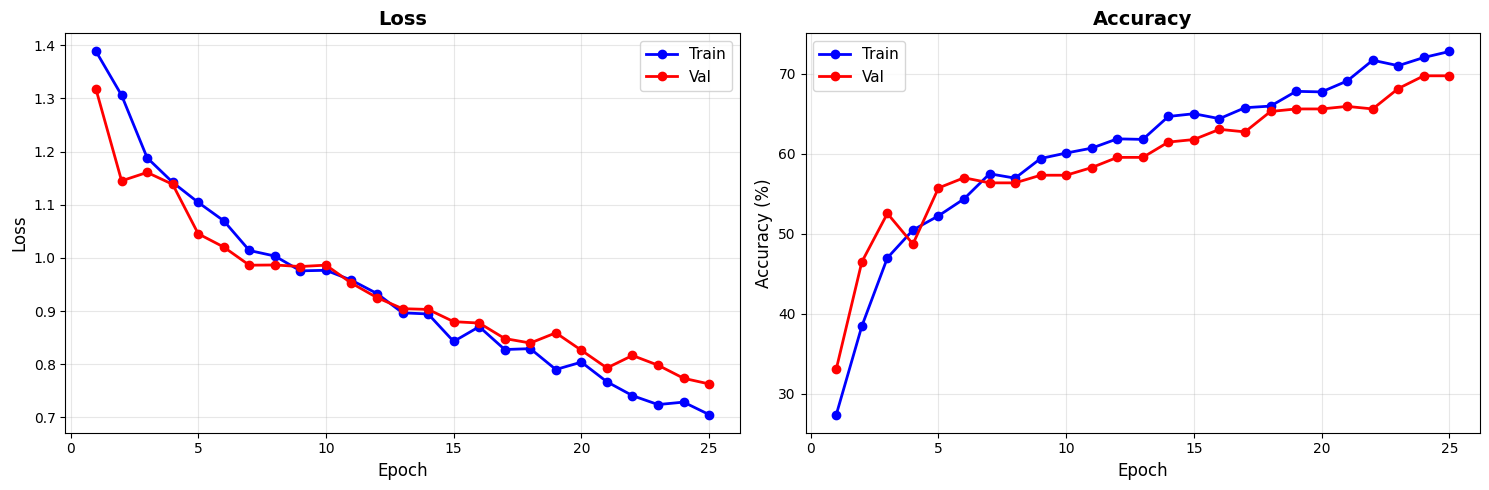

💾 Plot saved!


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / '06_optimized_cnn_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Plot saved!")

## 9️⃣ ניתוח תוצאות

In [9]:
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
acc_gap = final_train_acc - final_val_acc

print("="*60)
print("📊 Final Results")
print("="*60)
print(f"🎯 Best Val Accuracy: {best_val_acc:.2f}%")
print(f"📈 Final Train Acc: {final_train_acc:.2f}%")
print(f"📉 Final Val Acc: {final_val_acc:.2f}%")
print(f"⚠️  Overfitting Gap: {acc_gap:.2f}%")
print(f"⏱️  Training Time: {total_time/60:.1f} minutes")
print(f"🔢 Parameters: {total_params:,}")

if acc_gap < 5:
    print("\n✅ Excellent! Minimal overfitting.")
elif acc_gap < 10:
    print("\n👍 Good! Some overfitting but acceptable.")
else:
    print("\n⚠️  Still overfitting. Consider more regularization.")

print("="*60)

📊 Final Results
🎯 Best Val Accuracy: 69.75%
📈 Final Train Acc: 72.78%
📉 Final Val Acc: 69.75%
⚠️  Overfitting Gap: 3.04%
⏱️  Training Time: 20.6 minutes
🔢 Parameters: 12,902,308

✅ Excellent! Minimal overfitting.


## 🔟 שמירת תוצאות

In [10]:
results = {
    'model_name': 'SimpleCNN_Optimized',
    'num_epochs_ran': len(history['train_loss']),
    'max_epochs': config.NUM_EPOCHS,
    'batch_size': config.BATCH_SIZE,
    'learning_rate': config.LEARNING_RATE,
    'early_stopping_patience': patience,
    'best_val_acc': float(best_val_acc),
    'final_train_acc': float(final_train_acc),
    'final_val_acc': float(final_val_acc),
    'overfitting_gap': float(acc_gap),
    'total_params': total_params,
    'training_time_minutes': total_time / 60,
    'history': history
}

results_path = config.LOGS_DIR / 'simple_cnn_optimized_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"💾 Results saved to: {results_path}")

💾 Results saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\simple_cnn_optimized_results.json


## 📝 סיכום

### ✨ מה שיפרנו:
1. **מהירות:** פחות פרמטרים = אימון מהר יותר
2. **Overfitting:** Dropout חזק + Early stopping
3. **יעילות:** עצירה אוטומטית כשלא משתפר

### 🚀 הצעד הבא:
במחברת הבאה נוסיף **Batch Normalization** לשיפור נוסף!